In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
device = torch.device('cpu')

# Define the exact solution
def exact_solution(x, t):
    return torch.sin(x)*torch.cos(pi*t)

def initial_condition(x):
    return torch.sin(x)

def initial_condition_t(x):
    return 0*torch.cos(x)


In [3]:
# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

x_init = 8*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init = torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition(init[:,0]).reshape(-1, 1)
u_init_t = 0*initial_condition(init[:,0]).reshape(-1, 1)

xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = 0*torch.sin(tb_left)

xb_right = 8*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = 0*torch.sin(2*pi - tb_right)

x_interior = 8*pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1).to(device)

training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), u_init.to(device), u_init_t.to(device), b_left.to(device),  b_right.to(device), u_b_l.to(device), u_b_r.to(device)), batch_size=500, shuffle=False)


In [4]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)



In [5]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = u_init.shape[1], n_hidden_layers=4, neurons=200)
my_network = my_network.to(device)

def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, u_initial, u_initial_t, bd_left, bd_right, ubl, ubr) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                u_initial_pred_ = model(initial)
                inputs = torch.ones(initial_pts, 1).to(device)
                grad_u_init = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inputs, create_graph=True)[0]
                u_init_t = grad_u_init[:, 1].reshape(-1, )

                # for left boundary
                bd_left.requires_grad = True
                bd_left_pred_ = model(bd_left)
                inputs = torch.ones(left_boundary_pts, 1).to(device)
                grad_bd_left = torch.autograd.grad(bd_left_pred_, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_left = grad_bd_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_left = torch.autograd.grad(u_bd_x_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_left = grad_u_bd_x_left[:, 0].reshape(-1, )
                inputs = torch.ones(left_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_xx_left = torch.autograd.grad(u_bd_xx_left, bd_left, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xxx_left = grad_u_bd_xx_left[:, 0].reshape(-1, )

                # for right boundary
                bd_right.requires_grad = True
                bd_right_pred_ = model(bd_right)
                inputs = torch.ones(right_boundary_pts, 1).to(device)
                grad_bd_right = torch.autograd.grad(bd_right_pred_, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_x_right = grad_bd_right[:, 0].reshape(-1, )
                inputs = torch.ones(right_boundary_pts, 1).reshape(-1, ).to(device)
                grad_u_bd_x_right = torch.autograd.grad(u_bd_x_right, bd_right, grad_outputs=inputs, create_graph=True)[0]
                u_bd_xx_right = grad_u_bd_x_right[:, 0].reshape(-1, )

                # residual calculation
                interior.requires_grad = True
                u_hat = model(interior)
                inputs = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = torch.autograd.grad(u_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xx = grad_u_x[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xx = torch.autograd.grad(u_xx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxx = grad_u_xx[:, 0].reshape(-1, )
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_xxx = torch.autograd.grad(u_xxx, interior, grad_outputs=inputs, create_graph=True)[0]
                u_xxxx = grad_u_xxx[:, 0].reshape(-1, )

                u_t = grad_u_hat[:, 1]
                inputs = torch.ones(residual_pts, 1).reshape(-1, ).to(device)
                grad_u_t = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]
                u_tt = grad_u_t[:, 1].reshape(-1, )

                # Item 1. below

                loss_ic = torch.mean((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )) ** p) + \
                          torch.mean((u_init_t.reshape(-1, )) ** p)
                loss_pde = torch.mean((u_tt.reshape(-1, ) + u_xxxx.reshape(-1, ) - (2-pi**2)*torch.sin(interior[:,0])*torch.cos(pi*interior[:,1])) ** p)
                loss_left_b = torch.mean((u_bd_x_left.reshape(-1, ) - ubl.reshape(-1, )) ** p) + \
                              torch.mean((u_bd_xx_left.reshape(-1, ) - ubl.reshape(-1, )) ** p)
                loss_right_b = torch.mean((bd_right_pred_.reshape(-1, ) - ubr.reshape(-1, )) ** p) + \
                               torch.mean((u_bd_xx_right.reshape(-1, ) - ubr.reshape(-1, )) ** p)

                loss = loss_ic + loss_pde + loss_left_b + loss_right_b

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [8]:
# n_epochs = 10000
# start_time = time.time()
# history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
# end_time = time.time()
# total_time = end_time - start_time
# print("Training time: {:.2f} seconds".format(total_time))


# with open('PINN_EB.pkl', 'wb') as f:
#     pickle.dump(history, f)

# f.close()

# model_state_dict = my_network.state_dict()

# # Save the model state dictionary to a file
# torch.save(model_state_dict, 'PINN_EB.pth')


In [9]:
# loading model

# Load the history from the pickle file
with open('PINN_EB.pkl', 'rb') as f:
    history = pickle.load(f)

# # Load the model architecture
# my_network = your_model_module.YourModelClass()  # Instantiate your model class

# Load the saved model state dictionary
model_state_dict = torch.load('PINN_EB.pth',  map_location=torch.device('cpu'))

# Load the model weights
my_network.load_state_dict(model_state_dict)


<All keys matched successfully>

In [10]:
x_test = torch.linspace(0, 8*pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
u_test_pred = my_network(test).reshape(-1,1)

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")


Relative Error Test:  5.337321013212204 %


In [11]:
import torch

u_sol = torch.zeros(200, 256)
x_test = torch.linspace(0, pi, 256).reshape(-1, 1)
t_test = torch.zeros(256).reshape(-1, 1)
dt = 1/200

# # Assuming my_network is your defined neural network model
# my_network = YourNetworkModel()

for i in range(200):
      # Increment t_test by dt
    test = torch.cat([x_test, t_test], dim=1)
  
  
    output = my_network(test)
    t_test += dt
    u_sol[i, :] = output.reshape(256)  # Reshape output to match u_sol[i, :]

# Rest of your code...
u1 = u_sol.T

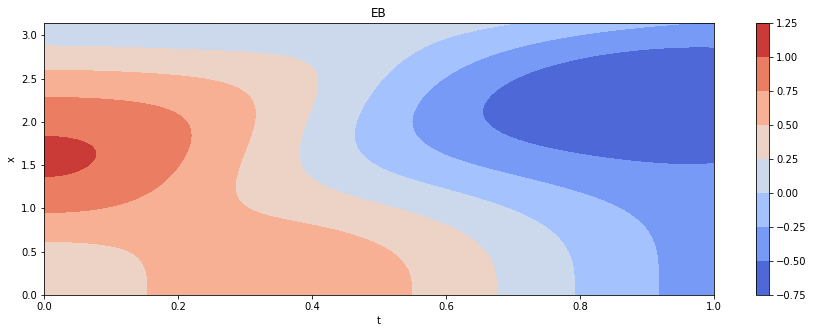

In [12]:
x = np.linspace(0, pi, 256)
t = np.linspace(0, 1, 200)

X, T = np.meshgrid(x, t)
# # Define custom color levels
#c_levels = np.linspace(np.min(u), np.max(u), 100)
u1 = u1.detach().numpy()
# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('EB')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [ ]:
import numpy as np
import scipy.io

# Example data
data = {
    'x': x,
    't': t,
    'u1': u1,
}

# Save data to .mat file
file_path = 'EB_foundation.mat'
scipy.io.savemat(file_path, data)


In [ ]:
x_test = 8*pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test).reshape(-1,1)
relative_error = torch.abs(u_test_pred - u_test)
u_test = u_test.reshape(-1,)

# reshaping and detach numpy
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)
u_test_pred = u_test_pred.reshape(-1, )

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_test_pred = u_test_pred.detach().numpy()
relative_error = relative_error.detach().numpy()





plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'

custom_font = FontProperties(fname=font_path)


        
CS1 = plt.tricontourf(x_test, t_test, u_test_pred, 20, cmap='rainbow')
#CS1 = plt.tricontourf(x_test, t_test, u_test, 20, cmap='rainbow')
#CS1 = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='rainbow')



cbar1 = plt.colorbar(CS1)
for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)



plt.xlabel('x', fontsize=20, fontproperties=custom_font)
plt.ylabel('t', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)
plt.savefig('PINN_EB.pdf', dpi = 300, bbox_inches = "tight")
#plt.savefig('Exact_EB.pdf', dpi = 300, bbox_inches = "tight")
#plt.savefig('Absolute_error_EB.pdf', dpi = 300, bbox_inches = "tight")

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# Assuming you have imported your data and defined necessary functions

# Rest of your code...

# # Convert the font size to points
font_size = 20
# ticks_font = FontProperties(family='Times New Roman', style='normal', size=font_size)





x_test = 8*pi*torch.rand(100000).reshape(-1,1)
t_test = torch.rand(100000).reshape(-1,1)
test = torch.cat([x_test, t_test],1)
u_test = exact_solution(x_test,t_test).reshape(-1,1)
u_test_pred = my_network(test).reshape(-1,1)
relative_error = torch.abs(u_test_pred - u_test)
u_test = u_test.reshape(-1,)

# reshaping and detach numpy
x_test = x_test.reshape(-1, )
t_test = t_test.reshape(-1, )
relative_error = relative_error.reshape(-1,)
u_test_pred = u_test_pred.reshape(-1, )

x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()
u_test_pred = u_test_pred.detach().numpy()
relative_error = relative_error.detach().numpy()





plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'

ticks_font = FontProperties(fname=font_path)

# Define the levels for contouring
levels = np.linspace(-1.5, 1.5, 20)

        
CS1 = plt.tricontourf(x_test, t_test, u_test_pred, levels, cmap='twilight')
#CS1 = plt.tricontourf(x_test, t_test, u_test, 20, cmap='twilight')
#CS1 = plt.tricontourf(x_test, t_test, relative_error, 20, cmap='rainbow')



#cbar1 = plt.colorbar(CS1)
for t in cbar1.ax.get_yticklabels():
    t.set_fontproperties(custom_font)
    t.set_fontsize(20)



plt.xlabel('x', fontsize=20, fontproperties=custom_font)
plt.ylabel('t', fontsize=20, fontproperties=custom_font)
plt.xticks(fontsize=20, fontproperties=custom_font)
plt.yticks(fontsize=20, fontproperties=custom_font)
#plt.savefig('Causal_EB.pdf', dpi = 300, bbox_inches = "tight")
plt.savefig('PINN_EB.pdf', dpi=500, bbox_inches="tight", format='pdf', backend='cairo')
#plt.savefig('Absolute_error_EB.pdf', dpi = 300, bbox_inches = "tight")


